In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,  CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
def detect_language(text):
    if text.split() == [] or text == " " or text.replace(" ", "").isdigit():
        return "NA"
    return detect(text)

In [40]:
def train_tfidf(df, name):
    vectorizer = TfidfVectorizer(stop_words="english", min_df=0.01)
    X = vectorizer.fit_transform(df["title"])

    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    data_raw = pd.DataFrame(denselist, columns=feature_names)

    # save words for new data process
    feature_names_df = pd.DataFrame(feature_names, columns=["feature_names"])
    feature_names_df.to_csv("../models/feature_names_{}.csv".format(name), index=False)

    return data_raw, X

def train_kmeans(data_raw, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, max_iter=1000)
    prediction = kmeans.fit_predict(data_raw)
    centers = pd.DataFrame(kmeans.cluster_centers_,columns=data_raw.columns)

    #pickle.dump(kmeans, open("kmeans_{}.pkl".format(n_clusters), "wb"))
    #print("Save model: kmeans_{}.pkl".format(n_clusters))

    data = data_raw.copy()
    data = data.append(centers)
    
    return data, prediction

In [7]:
def get_elbow(X, num):

    distortions = []
    for i in tqdm(range(1, num)):
        km = KMeans(
            n_clusters=i, init='random',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(X)
        distortions.append(km.inertia_)
    return distortions

def graph_elbow(distortions, num):
    f, ax = plt.subplots(figsize=(30, 22))
    plt.plot(range(1, 50), distortions, marker='.')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.grid()
    plt.show()

In [42]:
data20 = pd.read_csv("../data/papers_2016_2020.csv")
data15 = pd.read_csv("../data/papers_2013_2015.csv")
data12 = pd.read_csv("../data/papers_2010_2012.csv")

In [43]:
data_raw20, X20 = train_tfidf(data20, "2016-2020")
data_raw15, X15 = train_tfidf(data15, "2013-2015")
data_raw12, X12 = train_tfidf(data12, "2010-2012")

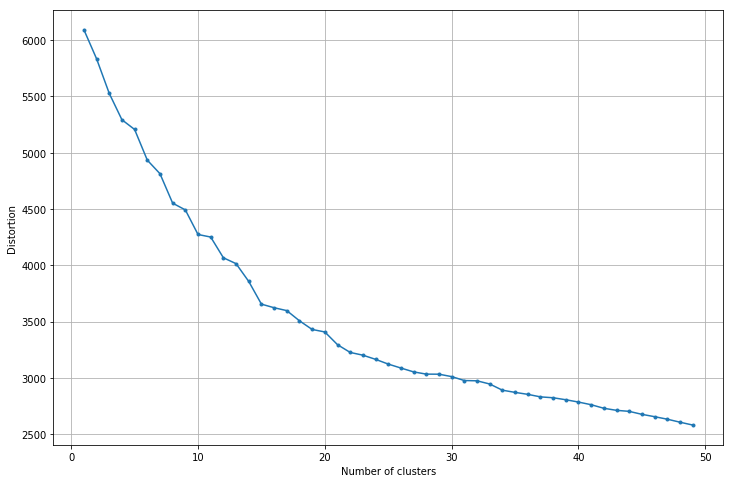

In [15]:
# plot
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1, 50), distortions, marker='.')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.grid()
plt.show()

In [17]:
n_clusters = 15
data, prediction = train_kmeans(data_raw, n_clusters)

In [35]:
def train_tsne(data, prediction, n_clusters, original_df):
    tsne = TSNE(n_components=2, verbose=1, random_state=10,  n_iter=1000, perplexity=5)
    tsne_results = tsne.fit_transform(data)

    # Save new df with columns prediction 2D
    data_vis = data.copy()

    data_vis['tsne-2d-one'] = tsne_results[:,0]
    data_vis['tsne-2d-two'] = tsne_results[:,1]

    centroids = data_vis[-n_clusters:]
    data_vis = data_vis[:-n_clusters]
    data_vis["prediction"] = prediction 

    # Guardar centroides para analizar nuevas predicciones
    #centroids.to_csv("centroids{}.csv".format(n_clusters), index=False)
    #data_vis.to_csv("data_vis{}.csv".format(n_clusters), index=False)

    #print("Saved files: ../data/processed/centroids{}.csv - ../data/processed/data_vis{}.csv".format(n_clusters, n_clusters)) 
    
    return data_vis,centroids

In [36]:
data_vis, centroids = train_tsne(data, prediction, n_clusters, data20)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 6515 samples in 0.098s...
[t-SNE] Computed neighbors for 6515 samples in 2.601s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6515
[t-SNE] Computed conditional probabilities for sample 2000 / 6515
[t-SNE] Computed conditional probabilities for sample 3000 / 6515
[t-SNE] Computed conditional probabilities for sample 4000 / 6515
[t-SNE] Computed conditional probabilities for sample 5000 / 6515
[t-SNE] Computed conditional probabilities for sample 6000 / 6515
[t-SNE] Computed conditional probabilities for sample 6515 / 6515
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.991600
[t-SNE] KL divergence after 1000 iterations: 1.031028


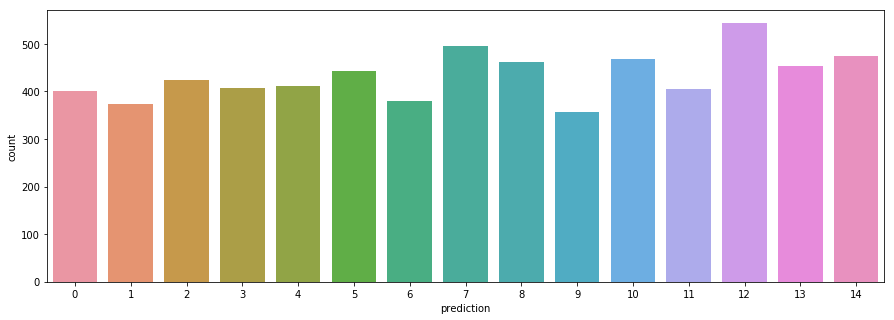

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="prediction", data=data_vis)

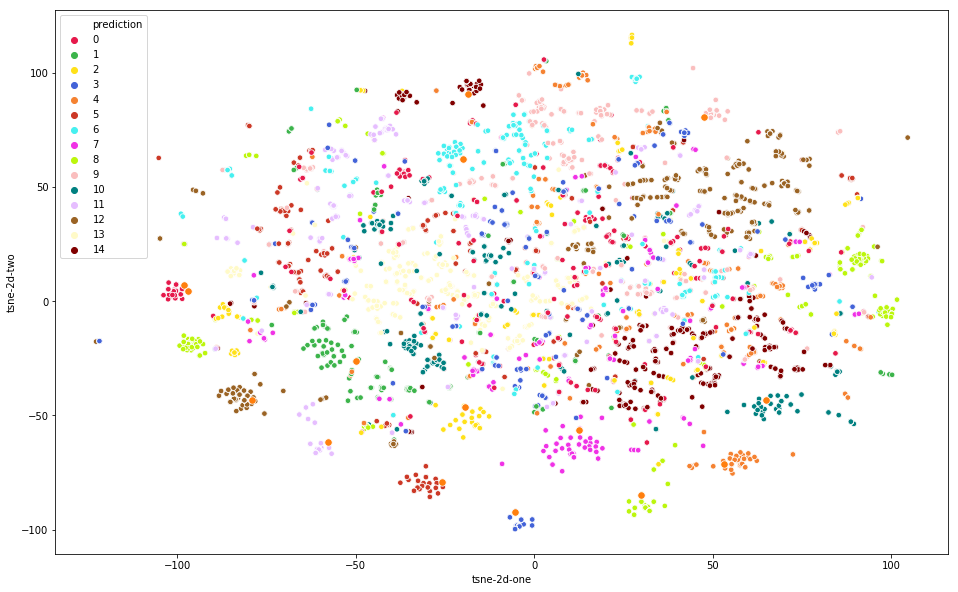

In [37]:
fig, ax = plt.subplots(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="prediction",
    palette=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
         '#cc3826', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', #9
        '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
         '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', #19
         '#fc0285', '#000000', "#4460ad", "#61022D", "#FCA650", 
         "#3EB5AD", "#9A1AFA", "#853BAD", "#89E7CE", "#576BEC", #29
         "#61A8EE", "#AD440F", "#F660A8", "#391612", "#C4CDC5", 
         "#2D6048", "#E27D6E", "#746679", "#689914", "#723D65", #39
         "#44E160", "#0086B3", "#784B57", "#fd6902", "#8052D7", 
         "#331921", "#8DF738", "#3ACF95", "#C40AC4", "#D0C016", #49
        "#331921", "#8DF738", "#3ACF95", "#C40AC4", "#D0C016"][0:n_clusters],
    legend="full",
    data=data_vis,
    ax=ax,
    s=30
)

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=centroids,
    ax=ax,
    s=55
)
#plt.savefig('clusters_x_words_2000.png')
plt.show()